📂 데이터 및 모델 로드 중...
The repository monologg/distilkobert contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/monologg/distilkobert .
 You can inspect the repository content at https://hf.co/monologg/distilkobert.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at monologg/distilkobert and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧐 테스트 데이터 평가 시작...

🏆 최종 상세 성적표 (Classification Report)
              precision    recall  f1-score   support

    팀플 없음(0)       0.50      0.25      0.33         4
    팀플 있음(1)       0.62      0.83      0.71         6

    accuracy                           0.60        10
   macro avg       0.56      0.54      0.52        10
weighted avg       0.57      0.60      0.56        10



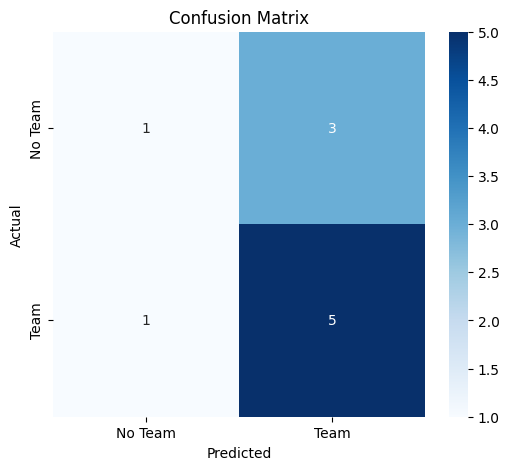


❌ 모델이 예측 실패한 케이스:
[1] 실제: 팀플O <-> 예측: 팀플X
   강의명/내용: 과목명: 기계학습의이해  ...
------------------------------
[2] 실제: 팀플X <-> 예측: 팀플O
   강의명/내용: 과목명: 언어학의이해  ...
------------------------------
[3] 실제: 팀플X <-> 예측: 팀플O
   강의명/내용: 과목명: 이슬람문명  ...
------------------------------
[4] 실제: 팀플X <-> 예측: 팀플O
   강의명/내용: 과목명: 국가정보의이해  ...
------------------------------


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 설정
MODEL_NAME = "monologg/distilkobert"
MAX_LEN = 128
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터셋 클래스
class SyllabusDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['FullText'].to_numpy()
        self.labels = df['Is_Teamplay'].to_numpy()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        return {
            'text': text,
            'input_ids': self.tokenizer.encode_plus(
                text, add_special_tokens=True, max_length=self.max_len,
                padding='max_length', truncation=True, return_tensors='pt'
            )['input_ids'].flatten(),
            'attention_mask': self.tokenizer.encode_plus(
                text, add_special_tokens=True, max_length=self.max_len,
                padding='max_length', truncation=True, return_tensors='pt'
            )['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.long)
        }

# 3. 데이터 및 모델 로드
test_df = pd.read_csv('test.csv')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.load_state_dict(torch.load('model.pt', map_location=device))
model.to(device)
model.eval()

test_ds = SyllabusDataset(test_df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=0)

# 4. 추론
print("Evaluation")
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for d in test_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        texts = d["text"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_texts.extend(texts)

# 5. 상세 리포트 출력 (여기가 중요!)
print("\n" + "="*50)
print(f"Classification Report")
print("="*50)
# target_names를 지정하여 0과 1이 무엇을 의미하는지 명시합니다.
print(classification_report(all_labels, all_preds, target_names=['팀플 없음(0)', '팀플 있음(1)']))
print("="*50)

# 6. 혼동 행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Team', 'Team'],
            yticklabels=['No Team', 'Team'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 7. 틀린 문제 분석
print("\n 모델이 예측 실패한 케이스:")
count = 0
for i in range(len(all_labels)):
    if all_preds[i] != all_labels[i]:
        count += 1
        print(f"[{count}] 실제: {'팀플O' if all_labels[i]==1 else '팀플X'} <-> 예측: {'팀플O' if all_preds[i]==1 else '팀플X'}")
        print(f"   강의명/내용: {all_texts[i].split('/')[0]} ...") # 강의명만 간단히 출력
        print("-" * 30)

if count == 0:
    print("All clear!")